In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
from copy import deepcopy
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
import time
import gc
import scipy
from scipy.signal import butter, filtfilt, argrelextrema
from scipy.interpolate import interp1d
from mup import MuReadout, MuSGD, MuAdam
import mup as mup
from datetime import datetime

In [3]:

# improve the ploting style
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 22
rcParams['mathtext.fontset'] = 'stix'

In [4]:
##### Function to load the dataset #####
def load_binary_dataset(trainset, validset, classes, class_binary_reduction=True, determination_des_classes=True, black_and_white_images=True):
    x_train, y_train_raw, x_valid, y_valid_raw = torch.tensor(trainset.data), torch.tensor(trainset.targets), torch.tensor(validset.data), torch.tensor(validset.targets)

    # Modification du format des données shape (n_data,1) -> (n_data, n_classes)
    y_train = torch.zeros((y_train_raw.shape[0], torch.max(y_train_raw)+1))
    for i, y in enumerate(y_train_raw):
        j = int(y.item())
        y_train[i,j] = 1

    y_valid = torch.zeros((y_valid_raw.shape[0], torch.max(y_valid_raw)+1))
    for i,y in enumerate(y_valid_raw):
        j = int(y.item())
        y_valid[i,j] = 1 

    if class_binary_reduction :
        if determination_des_classes :
            # Determination des classes
            class_list = []
            class_index = 0
            for i in range (x_train.shape[0]):
                if y_train[i, class_index] == 1:
                    class_list.append(x_train[i])
                    class_index += 1
                if len(class_list) == len(y_train[0]):
                    break
            for i, image in enumerate(class_list):
                plt.subplot(2, int(len(class_list)/2+1),i+1)
                plt.imshow(image)
                plt.xticks([])
                plt.yticks([])
            plt.show()
                    

        classe1 = [classes[0]]  # elk
        classe2 = [classes[1]]  # horse
        
        # Création des masques pour les échantillons appartenant à ces classes
        mask_classe1_train = y_train[:, classe1].sum(dim=1) > 0  # True si appartient à classe1
        mask_classe2_train = y_train[:, classe2].sum(dim=1) > 0  # True si appartient à classe2
        
        mask_classe1_valid = y_valid[:, classe1].sum(dim=1) > 0
        mask_classe2_valid = y_valid[:, classe2].sum(dim=1) > 0
        
        # Filtrage des exemples concernés
        mask_train = torch.logical_or(mask_classe1_train, mask_classe2_train)
        mask_valid = torch.logical_or(mask_classe1_valid, mask_classe2_valid)
        x_train, y_train = x_train[mask_train], y_train[mask_train]
        x_valid, y_valid = x_valid[mask_valid], y_valid[mask_valid]

        # Création du vecteur de labels binaires (1 pour classe1, 0 pour classe2)
        y_train = (y_train[:, classe1].sum(dim=1) > 0).to(dtype).unsqueeze(1)
        y_valid = (y_valid[:, classe1].sum(dim=1) > 0).to(dtype).unsqueeze(1)
        
        # Avec tanh
        
        # x_train = 2*(x_train-0.5)
        # y_train = 2*(y_train-0.5)
        # x_valid = 2*(x_valid-0.5)
        # y_valid = 2*(y_valid-0.5)


    if black_and_white_images :
        x_train = 0.299*x_train[:,:,:,0] + 0.587*x_train[:,:,:,1] + 0.114*x_train[:,:,:,2]
        x_valid = 0.299*x_valid[:,:,:,0] + 0.587*x_valid[:,:,:,1] + 0.114*x_valid[:,:,:,2]
        for i, image in enumerate(x_train[0:10]):
            plt.subplot(2, int(len(x_train[0:10])/2+1),i+1)
            plt.imshow(image, cmap = 'grey')
            plt.xticks([])
            plt.yticks([])
        plt.show()
        x_train, x_valid = (x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])).to(dtype), x_valid.reshape(x_valid.shape[0], x_valid.shape[1]*x_valid.shape[2]).to(dtype)

    else :    
        x_train, x_valid = (x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3])).to(dtype), x_valid.reshape(x_valid.shape[0], x_valid.shape[1]*x_valid.shape[2]*x_valid.shape[3]).to(dtype)
    
    return x_train, y_train, x_valid, y_valid

In [5]:
##### Function to generate the models to train #####

def model_dico_generator(input_size, width_list, length_list):
    model_dico = {'muP': {}, 'models': {}}
    
    for width in width_list:
        width_key = width
        
        # Initialiser les grands blocs
        if width_key not in model_dico['muP']:
            model_dico['muP'][width_key] = {}
        if width_key not in model_dico['models']:
            model_dico['models'][width_key] = {}
        
        for length in length_list:
            length_key = length
            
            # Initialiser les sous-blocs
            if length_key not in model_dico['muP'][width_key]:
                model_dico['muP'][width_key][length_key] = {}
            if length_key not in model_dico['models'][width_key]:
                model_dico['models'][width_key][length_key] = {}
            
            # Build muP dico
            model_dico['muP'][width_key][length_key]['architecture'] = [input_size] + [128]*(length-1) + [1]
            
            if length == 2:
                model_dico['muP'][width_key][length_key]['training'] = {
                    'Fully trained' : [True]*length,
                    'First trained' : [True] + [False]*(length-1),
                    'Fine tuning'  : [False]*(length-1) + [True]
                }            
            else:
                model_dico['muP'][width_key][length_key]['training'] = {
                    'Fully trained'     : [True]*length,
                    'Extremities trained': [True] + [False]*(length-2) + [True],
                    'First trained'     : [True] + [False]*(length-1),
                    'Fine tuning'       : [False]*(length-1) + [True]
                }

            # Build models dico
            model_dico['models'][width_key][length_key]['architecture'] = [input_size] + [width]*(length-1) + [1]
            
            if length == 2:
                model_dico['models'][width_key][length_key]['training'] = {
                    'Fully trained' : [True]*length,
                    'First trained' : [True] + [False]*(length-1)
                }
            else:
                model_dico['models'][width_key][length_key]['training'] = {
                    'Fully trained'     : [True]*length,
                    'Extremities trained': [True] + [False]*(length-2) + [True],
                    'First trained'     : [True] + [False]*(length-1)
                }            
    
    return model_dico


In [6]:
##### Model constructor #####

def is_trainable(p):
    return p.requires_grad

class torch_FNN(nn.Module):
    def __init__(self, list_of_layer_size, trained_layer_list=None, 
                 dropout=0.0, device='cpu', fine_tuning=False, muP=False, 
                 base_model=None, base_model_fine_tuning=None,
                 predetermined_layer=None):
        super(torch_FNN, self).__init__()
        torch.manual_seed(int(time.time())) 
        self.device = device
        self.binary = (list_of_layer_size[-1] == 1)
        self.dropout = dropout
        self.fine_tuning = fine_tuning
        # Enregistrement de l'architecture et des attributs pour la sauvegarde
        self.input_dimension = list_of_layer_size[0]
        self.architecture = {'Architecture' : list_of_layer_size, 'Dropout' : dropout, 'Binary' : self.binary}
        self.list_of_layer_size = list_of_layer_size
        self.training_time = None
        self.observation_interval = 10
        self.observation_rate = self.observation_interval  # alias pour post-traitement
        self.fine_tuning_interval = None
        self.fine_tuning_duration = None
        self.muP = muP
        self.base_model = base_model
        self.base_model_fine_tuning = base_model_fine_tuning
        self.predetermined_layer = predetermined_layer
        self.fraction_minibatch = None
        # Choix de l'activation de sortie
        self.activation = nn.Sigmoid() if self.binary else nn.Softmax(dim=1)

        # Initialisation de la liste des couches à entraîner
        if trained_layer_list is None:
            self.trained_list = [True] * (len(list_of_layer_size) - 1)
        else:
            self.trained_list = trained_layer_list

        # Construction du modèle
        layers = []
        for i in range(1, len(list_of_layer_size)):

            input_dim, output_dim = list_of_layer_size[i - 1], list_of_layer_size[i]
                        
            if i == len(list_of_layer_size) - 1:
                if self.muP: 
                    layer = MuReadout(input_dim, output_dim).to(device)
                    if self.predetermined_layer is not None and self.predetermined_layer[0][i-1]:
                        layer.weight.data.copy_(self.predetermined_layer[1][i-1]['weight'])
                        layer.bias.data.copy_(self.predetermined_layer[1][i-1]['bias'])

                else : 
                    layer = nn.Linear(input_dim, output_dim).to(device)
                    if self.predetermined_layer is not None and self.predetermined_layer[0][i-1]:
                        layer.weight.data.copy_(self.predetermined_layer[1][i-1]['weight'])
                        layer.bias.data.copy_(self.predetermined_layer[1][i-1]['bias'])

            else :
                layer = nn.Linear(input_dim, output_dim).to(device)
                if self.predetermined_layer is not None and self.predetermined_layer[0][i-1]:
                    layer.weight.data.copy_(self.predetermined_layer[1][i-1]['weight'])
                    layer.bias.data.copy_(self.predetermined_layer[1][i-1]['bias'])
                    
            for param in layer.parameters():
                param.requires_grad = self.trained_list[i - 1]
            layers.append(layer)
            
            if i < len(list_of_layer_size) - 1:
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(self.dropout))
            else:
                layers.append(self.activation)

        self.model = nn.Sequential(*layers)
        self.best_1st_layer = None
        
        # Entraînement
        self.loss_fn = nn.MSELoss()
        
        self.optimizer = None
        self.lr_scheduler = None
        
        self.fine_tuning_optimizer = None
        self.fine_tuning_lr_scheduler = None

        # Trajectoires
        self.training_loss_trajectory = []
        self.validation_loss_trajectory = []
        self.accuracy_trajectory = []
        
        self.first_layer_trajectory = None
        self.second_layer_trajectory = None
        
        self.last_layer_fine_tuned_training_loss_trajectory = []
        self.last_layer_fine_tuned_validation_loss_trajectory = []
        self.last_layer_fine_tuned_accuracy_trajectory = []
        
        self.last_layer_fine_tuned_accuracy_trajectory_at_one_step = []
        self.last_layer_fine_tuned_training_loss_trajectory_at_one_step = []
        self.last_layer_fine_tuned_validation_loss_trajectory_at_one_step = []
        
        self.fine_tuning = None
        self.hierarchical_training = None
        self.layer_switch_interval = None
    
    def lr_range_test(self, training_inputs, training_targets, validation_inputs, validation_targets, begin_lr=-10, end_lr=1, n_points=20, n_minibatch=10, fraction_minibatch=0.5, plot=True):
        
        training_inputs = training_inputs.to(self.device)
        training_targets = training_targets.to(self.device)
        validation_inputs = validation_inputs.to(self.device)
        validation_targets = validation_targets.to(self.device)
        
        index = 0
        for i, layer in enumerate(self.model):
            if isinstance(layer, nn.Linear):
                for param in layer.parameters():
                    param.requires_grad = self.trained_list[index]
                index += 1

        # Mise à jour des paramètres entraînables
        self.trainable_parameters = list(filter(is_trainable, self.model.parameters()))
        
        # Initialisation de l'optimiseur et du scheduler
        lrs = np.logspace(begin_lr, end_lr, n_points)
        training_losses = []
        
        for i, lr in enumerate(lrs) :
            if self.muP:
                self.optimizer = mup.MuAdam(self.trainable_parameters, lr=lr)            
            else:
                self.optimizer = optim.Adam(self.trainable_parameters, lr=lr)
            
            # Calcul du nombre d'itérations
            
            for epoch in range(n_minibatch):
                # Minibatch dynamique
                batch_size = int(training_inputs.shape[0] * fraction_minibatch)
                indices = torch.randperm(training_inputs.shape[0])[:batch_size]
                minibatch_inputs = training_inputs[indices]
                minibatch_targets = training_targets[indices]

                # Forward pass
                pred = self.model(minibatch_inputs)
                loss = self.loss_fn(pred, minibatch_targets)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                #self.lr_scheduler.step()
                
            training_losses += [loss.item()]
        if plot :
            plt.plot(lrs,training_losses)
            plt.xscale('log')
            plt.show()
        return lrs, training_losses
    
    def find_best_ridge(self, begin_lambda, end_lambda, training_inputs, training_targets,
                        test_inputs, test_targets, validation_inputs, validation_targets, 
                        lr, n_points=50, n_iterations=100, fraction_minibatch=0.2, plot_lambda=True, 
                        muP=False, fine_tuning=False, n_fine_tuning_iterations=100):
        
        training_inputs = training_inputs.to(self.device)
        training_targets = training_targets.to(self.device)
        test_inputs = test_inputs.to(device)
        test_targets = test_targets.to(device)
        validation_inputs = validation_inputs.to(self.device)
        validation_targets = validation_targets.to(self.device)
        
        index = 0
        for i, layer in enumerate(self.model):
            if isinstance(layer, nn.Linear):
                for param in layer.parameters():
                    param.requires_grad = self.trained_list[index]
                index += 1

        # Mise à jour des paramètres entraînables
        self.trainable_parameters = list(filter(is_trainable, self.model.parameters()))
        
        lambdas = np.logspace(begin_lambda, end_lambda, n_points)
        accuracies = []
        validation_losses = []
        training_losses = []
        for i, lambda_ in enumerate(lambdas):
            if not fine_tuning :
                if muP:
                    self.optimizer = mup.MuAdam(self.trainable_parameters, lr=lr, weight_decay=lambda_)
                else:
                    self.optimizer = torch.optim.Adam(self.trainable_parameters, lr=lr, weight_decay=lambda_)
                
                for iteration in range (n_iterations):
                    minibatch_indicies = torch.randperm(int(training_inputs.shape[0]*fraction_minibatch))
                    training_inputs_minibatch, training_targets_minibatch = training_inputs[minibatch_indicies], training_targets[minibatch_indicies]
                    
                    pred = self.model(training_inputs_minibatch)
                    loss = self.loss_fn(pred, training_targets_minibatch)
                    
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                validation_pred = self.model(validation_inputs)
                validation_loss = self.loss_fn(validation_pred, validation_targets)
                validation_losses.append(validation_loss.item())
                accuracy = ((validation_pred > 0.5) == validation_targets).float().mean()
                accuracies.append(accuracy)

            
            else :
                if muP:
                    self.optimizer = mup.MuAdam(self.trainable_parameters, lr=lr)#, weight_decay=lambda_)
                else:
                    self.optimizer = torch.optim.Adam(self.trainable_parameters, lr=lr)#, weight_decay=lambda_)
                
                for iteration in range (n_iterations):
                    minibatch_indicies = torch.randperm(int(training_inputs.shape[0]*fraction_minibatch))
                    training_inputs_minibatch, training_targets_minibatch = training_inputs[minibatch_indicies], training_targets[minibatch_indicies]
                    
                    pred = self.model(training_inputs_minibatch)
                    loss = self.loss_fn(pred, training_targets_minibatch)
                    
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                                
                # Activate training only for the last layer
                index = 0
                for j, layer in enumerate(self.model):
                    if isinstance(layer, nn.Linear):
                        if index != len(self.trained_list)-1:
                            for param in layer.parameters() :
                                param.requires_grad = False
                        else :
                            for param in layer.parameters() :
                                param.requires_grad = True
                        index += 1
                self.fine_tuning_trainable_parameters = list(filter(is_trainable, self.model.parameters()))

                if muP:
                    self.fine_tuning_optimizer = mup.MuAdam(self.fine_tuning_trainable_parameters, lr=lr, weight_decay=lambda_)
                else:
                    self.fine_tuning_optimizer = torch.optim.Adam(self.fine_tuning_trainable_parameters, lr=lr, weight_decay=lambda_)
                
                # Fine tune
                for j in range(n_fine_tuning_iterations):        
                    # Generate a minibatch  
                    minibatch_indicies = torch.randperm(int(test_inputs.shape[0]*fraction_minibatch))
                    test_inputs_minibatch, test_targets_minibatch = test_inputs[minibatch_indicies].to(device), test_targets[minibatch_indicies].to(device)
                    
                    # Assess the model
                    pred = self.model(test_inputs_minibatch)
                    loss = self.loss_fn(pred, test_targets_minibatch)
                    
                    self.fine_tuning_optimizer.zero_grad()
                    loss.backward()
                    self.fine_tuning_optimizer.step()
                loss = self.loss_fn(pred, test_targets_minibatch)
                training_losses.append(loss.item())
                
                validation_pred = self.model(validation_inputs)
                validation_loss = self.loss_fn(validation_pred, validation_targets)
                validation_losses.append(validation_loss.item())
                accuracy = ((validation_pred > 0.5) == validation_targets).float().mean()
                accuracies.append(accuracy)
        return lambdas, accuracies, validation_losses, training_losses
        

    def training_layers(self, training_inputs, training_targets, test_inputs, test_targets, validation_inputs, validation_targets,
                        n_iterations=None,kappa=2, observation_interval=10, lr=1e-2, lr_decay_rate=1e8, lr_decay_norm=0,
                        trained_layer_list=None, fraction_minibatch=0.1, verbose=True,
                        fine_tuning=False, lr_fine_tuning =1e-3, fine_tuning_interval=100, fine_tuning_duration=1000, 
                        lambda_ridge=0, plot_fine_tuning=True, memorize_1st_layer=False, memorize_2nd_layer=False,
                        memorize_1st_best_layer=False, hierarchical_training=False, layer_switch_interval=2000):
        
        # Horodatage de début d'entraînement
        start_time = time.time()

        self.fraction_minibatch = fraction_minibatch
        self.architecture = self.architecture |{"Learning rate": lr,
                                                "Learning rate decay": lr_decay_rate,
                                                "Decay norm": lr_decay_norm,
                                                "Fraction minibatch": fraction_minibatch,
                                                "Kappa": kappa,
                                                "Observation interval": observation_interval,
                                                "Fine tuning interval": fine_tuning_interval,
                                                "Fine tuning duration": fine_tuning_duration,
                                                "Fine tuning learning rate": lr_fine_tuning,
                                                "Plot fine tuning": plot_fine_tuning,
                                                "Lambda ridge fine tuning" : lambda_ridge
                                                }

        
        # Passage en tenseurs et envoie sur le bon device
        training_inputs = training_inputs.to(self.device)
        training_targets = training_targets.to(self.device)
        test_inputs = test_inputs.to(self.device)
        test_targets = test_targets.to(self.device)
        validation_inputs = validation_inputs.to(self.device)
        validation_targets = validation_targets.to(self.device)
        
        self.fine_tuning = fine_tuning
        self.hierarchical_training = hierarchical_training
        self.layer_switch_interval = layer_switch_interval
        
        # Mise à jour du gel des couches si précisé
        if trained_layer_list is not None:
            index = 0
            self.trained_list = trained_layer_list
            for i, layer in enumerate(self.model):
                if isinstance(layer, nn.Linear):
                    for param in layer.parameters():
                        param.requires_grad = self.trained_list[index]
                        index += 1

        # Mise à jour des paramètres entraînables
        self.trainable_parameters = list(filter(is_trainable, self.model.parameters()))
        self.fine_tuning_trainable_parameters = None
        
        # Initialisation de l'optimiseur et du scheduler
        
        linear_layers = [layer for layer in self.model if isinstance(layer,nn.Linear)]
        if self.muP:
            if self.predetermined_layer is not None:
                for layer in self.predetermined_layer[1]:
                    if hasattr(layer, '_has_rescaled_params') and layer._has_rescaled_params :
                        layer._has_rescaled_params = False 
            mup.set_base_shapes(self.model, self.base_model.model)
            self.optimizer = mup.MuAdam(self.trainable_parameters, lr=lr)
        else:
            self.optimizer = optim.Adam(self.trainable_parameters, lr=lr)
        self.lr_scheduler = optim.lr_scheduler.StepLR(self.optimizer, lr_decay_rate, lr_decay_norm)

        if memorize_1st_layer :
            self.first_layer_trajectory = []
            self.first_layer_trajectory_tensor = torch.cat([self.model[0].weight.data, self.model[0].bias.data.unsqueeze(1)], dim=1).unsqueeze(2)

            
        if memorize_2nd_layer :
            self.second_layer_trajectory = []
            self.second_layer_trajectory_tensor = torch.cat([self.model[3].weight.data, self.model[3].bias.data.unsqueeze(1)], dim=1).unsqueeze(2)
        
        
        # Calcul du nombre d'itérations
        self.observation_interval = observation_interval
        self.observation_rate = observation_interval
        n_iterations = int(training_inputs.shape[1] ** kappa) if n_iterations is None else n_iterations

        for epoch in range(n_iterations):
            # Minibatch dynamique
            batch_size = int(training_inputs.shape[0] * fraction_minibatch)
            indices = torch.randperm(training_inputs.shape[0])[:batch_size]
            minibatch_inputs = training_inputs[indices]
            minibatch_targets = training_targets[indices]

            # Forward pass
            pred = self.model(minibatch_inputs)
            loss = self.loss_fn(pred, minibatch_targets)

            # Évaluation périodique
            if epoch % self.observation_interval == 0:
                with torch.no_grad():
                    val_pred = self.model(validation_inputs)
                    val_loss = self.loss_fn(val_pred, validation_targets)

                    if self.binary:
                        acc = (val_pred.round() == validation_targets).float().mean()
                    else:
                        pred_classes = torch.argmax(val_pred, dim=1)
                        true_classes = torch.argmax(validation_targets, dim=1)
                        acc = (pred_classes == true_classes).float().mean()

                    if memorize_1st_best_layer and acc > np.max([0] + self.accuracy_trajectory)  :
                        self.best_1st_layer = {'weights' : self.model[0].weight.data, 'bias' : self.model[0].bias.data}
                        
                    if memorize_1st_layer :
                        if epoch % 100 == 0 and epoch != 0 :
                            self.first_layer_trajectory.append(self.first_layer_trajectory_tensor)
                            self.first_layer_trajectory_tensor = torch.cat([self.model[0].weight.data, self.model[0].bias.data.unsqueeze(1)], dim=1).unsqueeze(2)
                        else :
                            self.first_layer_trajectory_tensor = torch.cat([self.first_layer_trajectory_tensor, torch.cat([self.model[0].weight.data, self.model[0].bias.data.unsqueeze(1)], dim=1).unsqueeze(2)], dim=2)
                            
                    
                    if memorize_2nd_layer :
                        if epoch % 100 == 0 and epoch != 0 :
                            self.second_layer_trajectory.append(self.second_layer_trajectory_tensor)
                            self.second_layer_trajectory_tensor = torch.cat([self.model[3].weight.data, self.model[3].bias.data.unsqueeze(1)], dim=1).unsqueeze(2)
                        else :
                            self.second_layer_trajectory_tensor = torch.cat([self.second_layer_trajectory_tensor, torch.cat([self.model[3].weight.data, self.model[3].bias.data.unsqueeze(1)], dim=1).unsqueeze(2)], dim=2)
                                                    
                    self.training_loss_trajectory.append(loss.item())
                    self.validation_loss_trajectory.append(val_loss.item())
                    self.accuracy_trajectory.append(acc.item())
                    
                    layer_means = []
                    for layer in self.model:
                        if isinstance(layer, nn.Linear):
                            mean_linear = layer.weight.mean().item()
                            layer_means.append(mean_linear)
                    
                if verbose:
                    print(f"Epoch {epoch} - Accuracy: {acc.item():.4f} - Train loss: {loss.item():.4f} - Val loss: {val_loss.item():.4f} - Matrices means - {layer_means}")

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()
            
            if hierarchical_training and epoch % layer_switch_interval == 0 :
                
                # Activate training only for the last layer
                linear_layers = [layer for layer in self.model if isinstance(layer, nn.Linear)]
                current_layer_index = (epoch // layer_switch_interval) % len(linear_layers[:-1])

                for i, layer in enumerate(linear_layers):
                    requires_grad = (i == current_layer_index)
                    for param in layer.parameters():
                        param.requires_grad = requires_grad
                
                self.trainable_parameters = list(filter(is_trainable, self.model.parameters()))
            
                self.optimizer = optim.Adam(self.trainable_parameters, lr=lr)

            
            # Fine tuning the last layer if it is not already trained
            if fine_tuning and not self.trained_list[-1] and epoch % fine_tuning_interval == fine_tuning_interval - 10 :  # If we are doing last layer untrained training
                # Copy the model and set on only the last layer for training
                last_layer_training_model = deepcopy(self.model)  # Copy the model
                
                self.fine_tuning_interval = fine_tuning_interval
                self.fine_tuning_duration = fine_tuning_duration
                
                # Activate training only for the last layer
                index = 0
                for j, layer in enumerate(last_layer_training_model):
                    if isinstance(layer, nn.Linear):
                        if index != len(self.trained_list)-1:
                            for param in layer.parameters() :
                                param.requires_grad = False
                        else :
                            for param in layer.parameters() :
                                param.requires_grad = True
                        index += 1
                self.fine_tuning_trainable_parameters = list(filter(is_trainable, last_layer_training_model.parameters()))

                if self.muP:
                    for layer in last_layer_training_model:
                        if hasattr(layer, '_has_rescaled_params') and layer._has_rescaled_params :
                            layer._has_rescaled_params = False 
                        mup.set_base_shapes(last_layer_training_model, self.base_model_fine_tuning.model, rescale_params=False)
                    self.fine_tuning_optimizer = mup.MuAdam(self.fine_tuning_trainable_parameters, lr=lr_fine_tuning)
                else : 
                    self.fine_tuning_optimizer = optim.Adam(self.fine_tuning_trainable_parameters, lr=lr_fine_tuning)
                self.fine_tuning_lr_scheduler = optim.lr_scheduler.StepLR(self.fine_tuning_optimizer, lr_decay_rate, lr_decay_norm)
                        
                # Initialization of the storage for the best performance of the fine tuning
                self.last_layer_fine_tuned_accuracy_trajectory += [0]
                self.last_layer_fine_tuned_training_loss_trajectory += [0]
                self.last_layer_fine_tuned_validation_loss_trajectory += [0]
                
                # Initialization of the performances trajectories storage
                self.last_layer_fine_tuned_training_loss_trajectory_at_one_step = []
                self.last_layer_fine_tuned_validation_loss_trajectory_at_one_step = []
                self.last_layer_fine_tuned_accuracy_trajectory_at_one_step = []
                
                # Fine tune
                for j in range(fine_tuning_duration):        
                    # Generate a minibatch  
                    minibatch_idx = torch.randperm(training_inputs.shape[0])[:batch_size]
                    minibatch_inputs, minibatch_targets = training_inputs[minibatch_idx], training_targets[minibatch_idx]
                    
                    # Assess the model
                    pred = last_layer_training_model(minibatch_inputs)
                    loss = self.loss_fn(pred, minibatch_targets)
                    
                    # Display performances
                    if j % observation_interval == 0:
                        validation_pred = last_layer_training_model(validation_inputs)
                        validation_loss = self.loss_fn(validation_pred, validation_targets)
                        
                        if self.binary :
                            acc = (validation_pred.round() == validation_targets).float().mean()
                        else :
                            pred_classes = torch.argmax(validation_pred, dim=1)
                            true_classes = torch.argmax(validation_targets, dim=1)
                            acc = (pred_classes == true_classes).float().mean()
                        
                        # Save best performances
                        if acc > self.last_layer_fine_tuned_accuracy_trajectory[-1]:
                            self.last_layer_fine_tuned_accuracy_trajectory[-1] = acc.cpu()
                            self.last_layer_fine_tuned_training_loss_trajectory[-1] = loss.item()
                            self.last_layer_fine_tuned_validation_loss_trajectory[-1] = validation_loss.item()
                        
                        # Save performances trajectory during training
                        self.last_layer_fine_tuned_accuracy_trajectory_at_one_step += [acc.cpu()]
                        self.last_layer_fine_tuned_training_loss_trajectory_at_one_step += [loss.item()]
                        self.last_layer_fine_tuned_validation_loss_trajectory_at_one_step += [validation_loss.item()]
                        
                        # Compute layers mean to that only the layer that should be trained are trained
                        layer_means = []
                        for layer in last_layer_training_model:
                            if isinstance(layer, nn.Linear):
                                mean_linear = layer.weight.mean().item()
                                layer_means.append(mean_linear)
                        # Display performances
                        if verbose :
                            print(f"Fine tuning iteration {j} - Accuracy : {acc} - Training Loss : {loss.item()} - Validation Loss : {validation_loss.item()} - Linear Layer Means : {layer_means}")
                    
                    # Backward pass on the fine tuned model
                    self.fine_tuning_optimizer.zero_grad()
                    loss.backward()
                    self.fine_tuning_optimizer.step()
                    self.fine_tuning_lr_scheduler.step()
                
            # if fine_tuning and not self.trained_list[-1] and epoch % fine_tuning_interval == 0 :  # If we are doing last layer untrained training
            #     # Copy the model and set on only the last layer for training
            #     last_layer_training_model = deepcopy(self.model)  # Copy the model
                
            #     # Generates features that should be fitted by the last layer
            #     second_to_last_layer_representation_model = nn.Sequential(*[deepcopy(layer) for layer in list(self.model.children())[:-1]])
            #     test_inputs_representation = second_to_last_layer_representation_model(test_inputs)
                
            #     # Replacing the last linear layer by the best linear separation that could be fitted by the datas (does it really find the best separation or the best regression? Is it the same for binary classification) 
            #     last_layer_training_model[-2] = (test_inputs_representation.t() @ test_inputs_representation + lambda_ridge*torch.eye(test_inputs_representation.shape())).linalg.inv() @ (test_inputs_representation.t() @ test_targets)
                
            #     self.fine_tuning_interval = fine_tuning_interval
                
            #     # Assess the model
            #     pred = last_layer_training_model(test_inputs)
            #     loss = self.loss_fn(pred, test_targets)
                
            #     # Display performances
            #     validation_pred = last_layer_training_model(validation_inputs)
            #     validation_loss = self.loss_fn(validation_pred, validation_targets)
                
            #     if self.binary :
            #         acc = (validation_pred.round() == validation_targets).float().mean()
            #     else :
            #         pred_classes = torch.argmax(validation_pred, dim=1)
            #         true_classes = torch.argmax(validation_targets, dim=1)
            #         acc = (pred_classes == true_classes).float().mean()
                
            #     # Display performances
            #     if verbose :
            #         print(f"Fine tuning step : Accuracy : {acc} - Training Loss : {loss.item()} - Validation Loss : {validation_loss.item()} - Linear Layer Means : {layer_means}")
            
                
                # Plot fine tuning trajectories
                if plot_fine_tuning :
                    plt.figure(1)
                    plt.plot(np.linspace(0,len(self.last_layer_fine_tuned_training_loss_trajectory_at_one_step)*self.observation_rate, len(self.last_layer_fine_tuned_training_loss_trajectory_at_one_step)), self.last_layer_fine_tuned_training_loss_trajectory_at_one_step, label = "Training loss", color = "orange")
                    plt.plot(np.linspace(0,len(self.last_layer_fine_tuned_validation_loss_trajectory_at_one_step)*self.observation_rate, len(self.last_layer_fine_tuned_validation_loss_trajectory_at_one_step)), self.last_layer_fine_tuned_validation_loss_trajectory_at_one_step, label="Validation loss", color = "green")
                    plt.xlim(0, len(self.last_layer_fine_tuned_training_loss_trajectory_at_one_step)*self.observation_rate)
                    plt.ylim(0, np.max([np.nan_to_num(self.last_layer_fine_tuned_training_loss_trajectory_at_one_step,nan=0) + np.nan_to_num(self.last_layer_fine_tuned_validation_loss_trajectory_at_one_step, nan=0)])+0.01)
                    plt.xlabel("Number of iterations")  
                    plt.ylabel("Loss")
                    plt.grid(alpha=0.3)
                    plt.title("Loss", pad = 20)
                    plt.legend()              

                    plt.figure(2)
                    plt.plot(np.linspace(0, len(self.last_layer_fine_tuned_accuracy_trajectory_at_one_step)*self.observation_rate, len(self.last_layer_fine_tuned_accuracy_trajectory_at_one_step)), self.last_layer_fine_tuned_accuracy_trajectory_at_one_step, label = "Best accuracy " + str(np.round(np.max(self.last_layer_fine_tuned_accuracy_trajectory_at_one_step), 2)))
                    plt.xlim(0, len(self.last_layer_fine_tuned_accuracy_trajectory_at_one_step)*self.observation_interval)
                    plt.ylim(0,1)
                    plt.yticks(np.linspace(0,1,11))
                    plt.xlabel("Number of iterations")  
                    plt.ylabel("Accuracy")
                    plt.grid(alpha=0.3)
                    plt.title("Accuracy", pad = 20)
                    plt.legend()

                    plt.subplots_adjust(wspace=5)
                    plt.show()                      
                
        # Enregistrement du temps d'entraînement
        self.training_time = f"{time.time() - start_time:.2f} seconds"
        return "Training done."


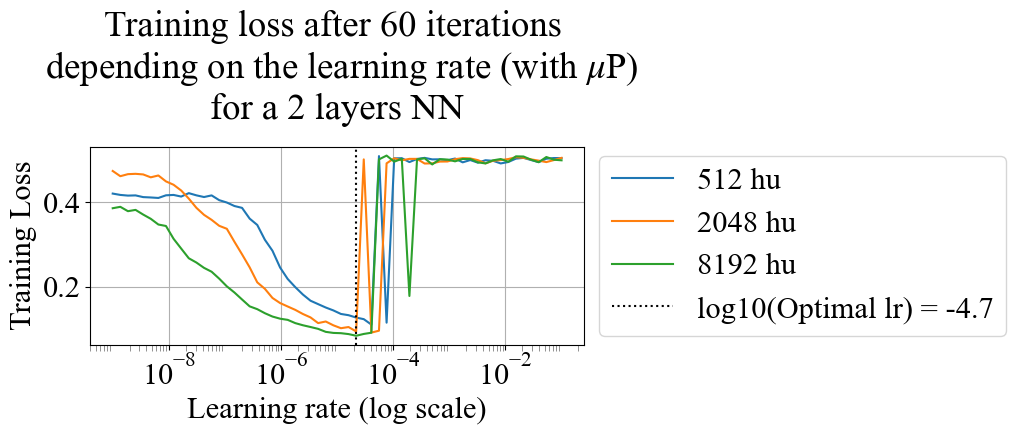

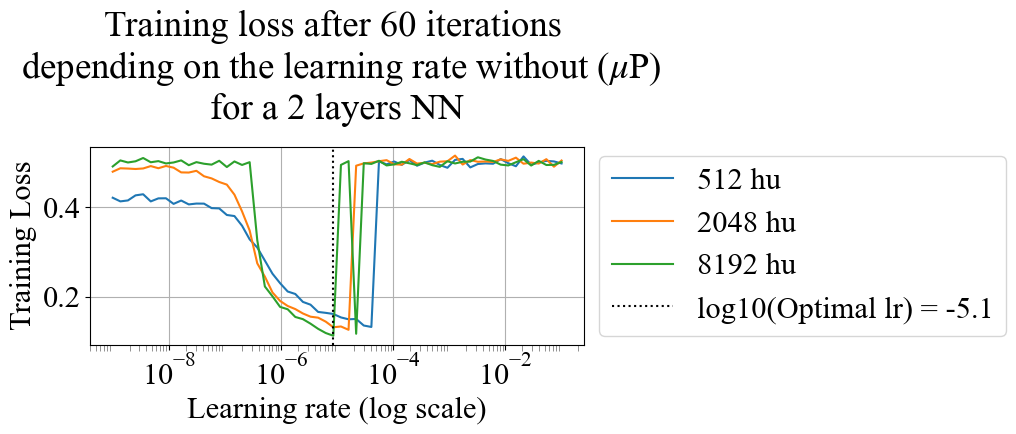

In [25]:
### Maximum update parametrisation (muP) ### Determine the optimal learning rate for the dataset #####
# This technique enables to have the same optimum of hyperparameters for different width of neural network #
# It relies on a scaling of the gradient step at the level of the preactivation layer #

dataset = 'car-plane'
# Widths
widths = [512, 2048, 8192]
length = 2
# Number of training step before comparing training losses
n_minibatch = 60

# Base model need for the muP renormalisation to work
base_model = torch_FNN([1024] + [128]*(length-1) + [1], [True] + [True]*2 + [True], 0, 'mps', True, muP=True)


muP_value = [True, False]
for muP in muP_value :
    lrs = []
    losses = []
    for width in widths :
        torch_model = torch_FNN([1024] + [width]*(length-1) + [1], [True] + [True]*(length-1), 0, 'mps', True, muP=muP)
        if muP :
            mup.set_base_shapes(torch_model, base_model)
        tested_lr, loss = torch_model.lr_range_test(x_train, y_train, x_valid, y_valid, begin_lr=-9, end_lr=-1, n_points=60, n_minibatch=n_minibatch, plot=False)
        lrs.append(tested_lr)
        losses.append(loss)
        plt.plot(tested_lr, loss, label = str(width) +  ' hu')    
        
    lrs_arr = np.array(lrs)
    losses_arr = np.array(losses)
    optimal_lr_index = np.unravel_index(np.argmin(losses_arr), losses_arr.shape)
    plt.xlabel('Learning rate (log scale)')
    plt.ylabel('Training Loss')
    if muP :    
        plt.title('Training loss after ' + str(n_minibatch) + ' iterations \n depending on the learning rate (with $\mu$P)\nfor a ' + str(length) + ' layers NN', pad=20)
    else :
        plt.title('Training loss after ' + str(n_minibatch) + ' iterations \n depending on the learning rate without ($\mu$P)\nfor a ' + str(length) + ' layers NN', pad=20)
    plt.axvline(x=lrs_arr[optimal_lr_index], linestyle = ':', color = 'black', label = 'log10(Optimal lr) = ' + str(round(np.log10(lrs_arr[optimal_lr_index]), 1)))
    plt.grid()
    plt.xscale('log')
    plt.xticks()
    plt.tick_params(which='minor', length=4, color='gray')
    ax = plt.gca()
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
    plt.tight_layout()
    plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
    os.makedirs('muP', exist_ok=True)
    plt.savefig('muP/muP_' + str(muP) + '_dataset_' + dataset + '_' + str(length) + '-layer_extremities_trained.svg', bbox_inches='tight')
    plt.savefig('muP/muP_' + str(muP) + '_dataset_' + dataset + '_' + str(length) + '-layer_extremities_trained.png', bbox_inches='tight')
    plt.show()

In [ ]:
### Maximum update parametrisation (muP) ### Determine the evolution of the optimal lr depending on the depth of the model #####
# This technique enables to have the same optimum of hyperparameters for different width of neural network #
# It relies on a scaling of the gradient step at the level of the preactivation layer #

# Widths
widths = [512, 2048, 8192]
lengths = [1, 2, 3]
dataset = 'elk-horse'
# Number of training step before comparing training losses
n_minibatch = 30

color_list = {1 : 'blue', 2 : 'red', 3 : 'green'}
# Base model need for the muP renormalisation to work


muP_value = [True]
for muP in muP_value :
    lrs = []
    losses = []
    for length in lengths :
        torch_model = torch_FNN([1024] + [2048]*length + [1], [True]*length + [True], 0, 'mps', True, muP=muP)
        if muP :
            base_model = torch_FNN([1024] + [128]*length + [1], [True] + [True]*2 + [True], 0, 'mps', True, muP=True)
            mup.set_base_shapes(torch_model, base_model)
        tested_lr, loss = torch_model.lr_range_test(x_train, y_train, x_valid, y_valid, begin_lr=-9, end_lr=-1, n_points=80, n_minibatch=n_minibatch, plot=False)
        lrs.append(tested_lr)
        losses.append(loss)
        plt.plot(tested_lr, loss, label = str(length+1) +  ' layers - 2048 hu', color = color_list[length])    
        
    lrs_arr = np.array(lrs)
    losses_arr = np.array(losses)
    optimal_lr_index = np.unravel_index(np.argmin(losses_arr), losses_arr.shape)
    plt.xlabel('Learning rate (log scale)')
    plt.ylabel('Training Loss')
    if muP :    
        plt.title('Training loss after ' + str(n_minibatch) + ' iterations \n depending on the learning rate (with $\mu$P)', pad=20)
    else :
        plt.title('Training loss after ' + str(n_minibatch) + ' iterations \n depending on the learning rate without ($\mu$P)', pad=20)
    plt.axvline(x=lrs_arr[optimal_lr_index], linestyle = ':', color = 'black', label = 'log10(Optimal lr) = ' + str(round(np.log10(lrs_arr[optimal_lr_index]), 1)))
    plt.grid()
    plt.xscale('log')
    plt.xticks()
    plt.tick_params(which='minor', length=4, color='gray')
    ax = plt.gca()
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
    plt.tight_layout()
    plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
    plt.savefig('muP/muP_' + str(muP) + '_dataset_' + dataset + '_2048hu_different_depth_with_muP.svg', bbox_inches='tight' )
    plt.savefig('muP/muP_' + str(muP) + '_dataset_' + dataset + '_2048hu_different_depth_with_muP.png', bbox_inches='tight')
    plt.show()

In [ ]:
### Maximum update parametrisation (muP) ### Determine the optimal regularisation coefficient for the model ####
# This technique enables to have the same optimum of hyperparameters for different width of neural network #
# It relies on a scaling of the gradient step at the level of the preactivation layer #

dataset = 'car-plane'
date = '07_07_25'
# Widths
widths = [512, 2048, 8192]
length = 3
color_list = {512 : 'blue', 2048 : 'red', 8192 : 'green'}
# Number of training step before comparing training losses
n_iterations = 200

# Base model need for the muP renormalisation to work
base_model = torch_FNN([1024] + [128]*(length-1) + [1], [True] + [False]*(length-2) + [False], 0, 'mps', True, muP=True)


muP_value = [True]
for muP in muP_value :
    lambdas = []
    accuracies = []
    validation_losses = []
    training_losses = []
    for width in widths :
        print(muP)
        torch_model = torch_FNN([1024] + [width]*(length-1) + [1], [True] + [False]*(length-2) + [False], 0, 'mps', True, muP=muP)
        if muP :
            mup.set_base_shapes(torch_model, base_model)
        tested_lambda, accuracy, validation_loss, training_loss = torch_model.find_best_ridge(-40, 5, x_train[:int(0.8*x_train.shape[0])], y_train[:int(0.8*y_train.shape[0])], 
                                                      x_train[int(4/5*x_train.shape[0]):], y_train[int(4/5*y_train.shape[0]):],
                                                      x_valid, y_valid,  lr=10**(-5.1), n_points=60, n_iterations=n_iterations, 
                                                      plot_lambda=True, muP=muP_value, fine_tuning=True, n_fine_tuning_iterations=1000)
        lambdas.append(tested_lambda)
        plt.figure(0)
        accuracy_np = np.array([a.cpu().item() if torch.is_tensor(a) else a for a in accuracy])
        validation_loss_np = np.array([a.cpu().item() if torch.is_tensor(a) else a for a in validation_loss])
        training_loss_np = np.array([a.cpu().item() if torch.is_tensor(a) else a for a in training_loss])
        accuracies.append(accuracy_np)
        validation_losses.append(validation_loss_np)
        training_losses.append(training_loss_np)

        plt.plot(tested_lambda, accuracy_np, label = str(length) + ' layers - ' + str(width) +  ' hu', color=color_list[width])    
        plt.figure(1)
        plt.plot(tested_lambda, validation_loss_np, label = str(length) + ' layers - ' + str(width) +  ' hu', color=color_list[width])
        plt.figure(2)
        plt.plot(tested_lambda, training_loss_np, label = str(length) + ' layers - ' + str(width) +  ' hu', color=color_list[width]) 
    plt.figure(0)
    lambdas_arr = np.array(lambdas)
    accuracies_arr = np.array(accuracies)
    optimal_lambda_index = np.unravel_index(np.argmax(accuracies_arr), accuracies_arr.shape)
    plt.xlabel('Lambda ridge (log scale)')
    plt.ylabel('Accuracy')
    if muP :    
        plt.title('Accuracy after ' + str(n_iterations) + ' iterations \n depending on the ridge factor (with $\mu$P)\nfor a ' + str(length) + ' layers NN', pad=20)
    else :
        plt.title('Accuracy after ' + str(n_iterations) + ' iterations \n depending on the ridge factor without ($\mu$P)\nfor a ' + str(length) + ' layers NN', pad=20)
    plt.axvline(x=lambdas_arr[optimal_lambda_index], linestyle = ':', color = 'black', label = 'log10(Optimal lambda) = ' + str(round(np.log10(lambdas_arr[optimal_lambda_index]), 1)))
    plt.grid()
    plt.xscale('log')
    plt.xticks()
    plt.tick_params(which='minor', length=4, color='gray')
    ax = plt.gca()
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
    plt.tight_layout()
    plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
    plt.savefig('Ridge_factor/' + date + '_Accuracy_' + str(muP) + '_dataset_' + dataset + '_' + str(length) + '-layer_first_trained.svg', bbox_inches='tight')
    plt.savefig('Ridge_factor/' + date + '_Accuracy_' + str(muP) + '_dataset_' + dataset + '_' + str(length) + '-layer_first_trained.png', bbox_inches='tight')
        
    plt.figure(1)
    lambdas_arr = np.array(lambdas)
    validation_loss_arr = np.array(validation_losses)
    optimal_lambda_index = np.unravel_index(np.argmin(validation_loss_arr), validation_loss_arr.shape)
    plt.xlabel('Lambda ridge (log scale)')
    plt.ylabel('Validation Loss')
    if muP :    
        plt.title('Validation loss after ' + str(n_iterations) + ' iterations \n depending on the ridge factor (with $\mu$P)\nfor a ' + str(length) + ' layers NN', pad=20)
    else :
        plt.title('Validation loss after ' + str(n_iterations) + ' iterations \n depending on the ridge factor without ($\mu$P)\nfor a ' + str(length) + ' layers NN', pad=20)
    plt.axvline(x=lambdas_arr[optimal_lambda_index], linestyle = ':', color = 'black', label = 'log10(Optimal lambda) = ' + str(round(np.log10(lambdas_arr[optimal_lambda_index]), 1)))
    plt.grid()
    plt.xscale('log')
    plt.xticks()
    plt.tick_params(which='minor', length=4, color='gray')
    ax = plt.gca()
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
    plt.tight_layout()
    plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
    os.makedirs('Ridge_factor', exist_ok=True)
    plt.savefig('Ridge_factor/' + date + '_Validation_loss_' + str(muP) + '_dataset_' + dataset + '_' + str(length) + '-layer_first_trained.svg', bbox_inches='tight')
    plt.savefig('Ridge_factor/' + date + '_Validation_loss_' + str(muP) + '_dataset_' + dataset + '_' + str(length) + '-layer_first_trained.png', bbox_inches='tight')
    
    plt.figure(2)
    lambdas_arr = np.array(lambdas)
    training_loss_arr = np.array(training_losses)
    optimal_lambda_index = np.unravel_index(np.argmin(training_loss_arr), training_loss_arr.shape)
    plt.xlabel('Lambda ridge (log scale)')
    plt.ylabel('Test Loss')
    if muP :    
        plt.title('Test loss after ' + str(n_iterations) + ' iterations \n depending on the regularisation factor (with $\mu$P)\nfor a ' + str(length) + ' layers NN', pad=20)
    else :
        plt.title('Test loss after ' + str(n_iterations) + ' iterations \n depending on the regularisation factor without ($\mu$P)\nfor a ' + str(length) + ' layers NN', pad=20)
    plt.axvline(x=lambdas_arr[optimal_lambda_index], linestyle = ':', color = 'black', label = 'log10(Optimal lambda) = ' + str(round(np.log10(lambdas_arr[optimal_lambda_index]), 1)))
    plt.grid()
    plt.xscale('log')
    plt.xticks()
    plt.tick_params(which='minor', length=4, color='gray')
    ax = plt.gca()
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
    plt.tight_layout()
    plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
    os.makedirs('Ridge_factor', exist_ok=True)
    plt.savefig('Ridge_factor/' + date + '_Test_loss_' + str(muP) + '_dataset_' + dataset + '_' + str(length) + '-layer_first_trained.svg', bbox_inches='tight')
    plt.savefig('Ridge_factor/' + date + '_Test_loss_' + str(muP) + '_dataset_' + dataset + '_' + str(length) + '-layer_first_trained.png', bbox_inches='tight')
    
    plt.show()

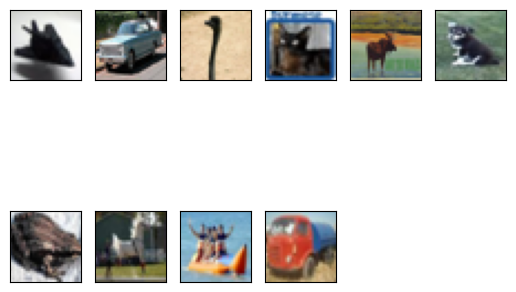

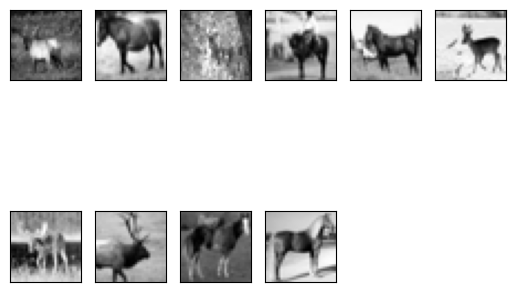

elk-horse
512 2
Fully trained
0
2025-07-18 18:18:35.754593


KeyboardInterrupt: 

In [13]:
##### AUTOMATIC TRAINING #####

dtype = torch.float32

transform_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # Apply the (x - mean)/var operation on the components of the data # if x is in [0,1] then Normalise(x) is in [-1,1] # is applied on the three channels RGB
])

# Data import
dtype = torch.float32
trainset = torchvision.datasets.CIFAR10(root = './datas', train= True, download = True, transform = transform_data)
validset = torchvision.datasets.CIFAR10(root = './datas', train = False, download = True, transform = transform_data)
datasets = {'elk-horse' : [4,7], 'car-plane' : [0,1], 'cat-dog' : [3,5]}

# Generate the dictionnary that contains the parameters of the models you want to train
input_size = 1024
width_dico = {'elk-horse' : [512], 'car-plane' : [512, 2048], 'cat-dog' : [512,2048,8192]}
length_list = [2, 3, 4]


# Define the duration of the training and the lr you want to use
n_epoch_dico = {'512hu' : 300000, '2048hu' : 75000, '8192hu' : 30000}
lr_dico = {'car-plane' : 10**(-5), 'elk-horse' : 10**(-5), 'cat-dog' : 10**(-5)}
fine_tuning_param_dico = {'512hu' : {'fine tuning interval' : 5000, 'fine tuning duration' : 6000}, 
                          '2048hu' : {'fine tuning interval' : 1875, 'fine tuning duration' : 2500}, 
                          '8192hu' : {'fine tuning interval' : 750, 'fine tuning duration' : 1000}}

# Saving parameters
number_of_save = 5
date = '18_07_25'

for dataset, classes in datasets.items():
    model_dico = model_dico_generator(input_size=input_size, width_list=width_dico[dataset], length_list=length_list)
    # Load datas
    train_input, train_target, valid_input, valid_target = load_binary_dataset(trainset, validset, classes)
    print(dataset)
    # For each model

    for width in model_dico['models'] :
        for length in model_dico['models'][width]:
            print(width, length)   
            # Load the architecture and the different type of training for the current model

                # For muP
            muP_architecture = model_dico['muP'][width][length]['architecture']
            muP_trained_list = model_dico['muP'][width][length]['training']
                # For the model
            model_architecture = model_dico['models'][width][length]['architecture']
            model_trained_list = model_dico['models'][width][length]['training']

            # For different type of training
            for type_of_training in model_dico['models'][width][length]['training'] :
                print(type_of_training)
                for save_index in range(number_of_save):
                    print(save_index)
                    print(datetime.now())
                    base_model = torch_FNN(muP_architecture, muP_trained_list[type_of_training], 0, 'mps', True, muP=True)
                    base_model_fine_tuning = torch_FNN(muP_architecture, muP_trained_list['Fine tuning'], 0, 'mps', True, muP=True)
                    torch_model = torch_FNN(model_architecture, model_trained_list[type_of_training], 0, 'mps', True, muP=True, 
                                            base_model=base_model, base_model_fine_tuning=base_model_fine_tuning)
                    if type_of_training != 'First trained':
                        torch_model.training_layers(training_inputs=train_input, training_targets=train_target,  
                                                    test_inputs=torch.tensor([0]), test_targets=torch.tensor([0]),
                                                    validation_inputs=valid_input, validation_targets=valid_target, 
                                                    n_iterations=n_epoch_dico[f'{width}hu'], kappa=3, observation_interval=10, 
                                                    lr=lr_dico[dataset], 
                                                    lr_decay_rate=1e8, lr_decay_norm=0.1, fraction_minibatch=1,
                                                    verbose=False, fine_tuning=False, lr_fine_tuning=lr_dico[dataset], 
                                                    fine_tuning_interval=2000, fine_tuning_duration=4000, 
                                                    plot_fine_tuning=False, memorize_1st_layer=False, memorize_2nd_layer=False)
                    else:
                        torch_model.training_layers(training_inputs=train_input, training_targets=train_target,  
                                                    test_inputs=torch.tensor([0]), test_targets=torch.tensor([0]),
                                                    validation_inputs=valid_input, validation_targets=valid_target, 
                                                    n_iterations=n_epoch_dico[f'{width}hu'], kappa=3, observation_interval=10, 
                                                    lr=lr_dico[dataset], 
                                                    lr_decay_rate=1e8, lr_decay_norm=0.1, fraction_minibatch=1,
                                                    verbose=False, fine_tuning=True, lr_fine_tuning=lr_dico[dataset], 
                                                    fine_tuning_interval=fine_tuning_param_dico[f'{width}hu']['fine tuning interval'], 
                                                    fine_tuning_duration=fine_tuning_param_dico[f'{width}hu']['fine tuning duration'], 
                                                    plot_fine_tuning=False, memorize_1st_layer=False, memorize_2nd_layer=False)
                
                    if number_of_save > 1 :
                        statistics = True
                    else : 
                        statistics = False

                    # Save the model
                    model = torch_model
                    if type_of_training == 'Fully trained':
                        model_name =  date + f'_CIFAR10_torch_model_({input_size}+{width}.{length-1}+1)_{dataset}'
                    elif type_of_training == 'Extremities trained':
                        model_name =  date + f'_CIFAR10_torch_model_({input_size}+{width}-{width}.{length-2}+1)_{dataset}'
                    elif type_of_training == 'First trained':
                        model_name =  date + f'_CIFAR10_torch_model_({input_size}+{width}-{width}.{length-2}-1)_{dataset}' #
                    save_path = 'Classifiers/' + date + '/' + model_name + '/'  if not statistics else 'Classifiers/' + date + '/' + model_name + '/' + f'save_{save_index}/' 
                    os.makedirs(save_path, exist_ok=True)
                    # torch.save(model , save_path + model_name + ".pt")


                    # Save Architecture
                    with open(save_path + "architecture.txt", "w", encoding="utf-8") as f:
                        for key, value in model.architecture.items():
                            f.write(f"{key} = {value}\n")

                    # Save performances of the model
                    os.makedirs(save_path + "figures/", exist_ok=True) 
                    # Plot accuracy = f(n)
                    plt.plot(np.linspace(0, len(model.accuracy_trajectory)*model.observation_rate, len(model.accuracy_trajectory)), model.accuracy_trajectory, label = "Best accuracy " + str(np.round(np.max(model.accuracy_trajectory), 2)))
                    plt.xlim(0, len(model.accuracy_trajectory)*model.observation_rate)
                    plt.ylim(0,1)
                    plt.yticks(np.linspace(0,1,11))
                    plt.xlabel("Number of iterations")  
                    plt.ylabel("Accuracy")
                    plt.grid(alpha=0.3)
                    plt.title("Accuracy of the " + model_name + " on the validation set", pad = 20)
                    plt.legend()
                    plt.savefig(save_path + "figures/accuracy_of_" + model_name + ".png", bbox_inches='tight')
                    plt.savefig(save_path + "figures/accuracy_of_" + model_name + ".svg", bbox_inches='tight')
                    data = np.column_stack((np.linspace(0, len(model.accuracy_trajectory)*model.observation_rate, len(model.accuracy_trajectory)), model.accuracy_trajectory)) 
                    np.savetxt(save_path +"figures/accuracy_of_" + model_name + ".txt", data, delimiter =",", header="n,accuracy")
                    plt.show() 
                    
                    # Plot training and validation loss = f(n)
                    plt.plot(np.linspace(0,len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory)), model.training_loss_trajectory, label = "Training loss", color = "orange")
                    plt.plot(np.linspace(0,len(model.validation_loss_trajectory)*model.observation_rate, len(model.validation_loss_trajectory)), model.validation_loss_trajectory, label="Validation loss", color = "green")
                    plt.xlim(0, len(model.training_loss_trajectory)*model.observation_rate)
                    plt.ylim(0, np.max([np.nan_to_num(model.training_loss_trajectory,nan=0), np.nan_to_num(model.validation_loss_trajectory, nan=0)])+0.01)
                    plt.xlabel("Number of iterations")  
                    plt.ylabel("Loss")
                    plt.grid(alpha=0.3)
                    plt.title("Loss of the " + model_name, pad = 20)
                    plt.legend()
                    plt.savefig(save_path + "figures/loss_of_" + model_name + ".png", bbox_inches='tight')
                    plt.savefig(save_path + "figures/loss_of_" + model_name + ".svg", bbox_inches='tight')
                    data = np.column_stack((np.linspace(0,len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory)), model.training_loss_trajectory))
                    np.savetxt(save_path + "figures/training_loss_of_" + model_name + ".txt", data, delimiter=",", header="n, training_loss")
                    data = np.column_stack((np.linspace(0,len(model.validation_loss_trajectory)*model.observation_rate, len(model.validation_loss_trajectory)), model.validation_loss_trajectory))
                    np.savetxt(save_path + "figures/validation_loss_of_" + model_name + ".txt", data, delimiter=",", header="n, validation_loss")
                    plt.show()
                    
                    # Plot accuracy = f(kappa)
                    kappa = [np.log(n)/np.log(model.input_dimension) for n in np.linspace(1, len(model.accuracy_trajectory)*model.observation_rate+1, len(model.accuracy_trajectory))]
                    plt.plot(kappa, model.accuracy_trajectory, label = "Best accuracy " + str(np.round(np.max(model.accuracy_trajectory), 2)))
                    plt.xlim(0, np.max(kappa))
                    plt.ylim(0,1)
                    plt.yticks(np.linspace(0,1,11))
                    plt.xlabel(r"$\kappa  = \frac{ln(n)}{ln(d)}$")  
                    plt.ylabel("Accuracy")
                    plt.grid(alpha=0.3)
                    plt.title("Accuracy of the " + model_name + " on the validation set", pad = 20)
                    plt.legend()
                    plt.savefig(save_path + "figures/kappa_accuracy_of_" + model_name + ".png", bbox_inches='tight')
                    plt.savefig(save_path + "figures/kappa_accuracy_of_" + model_name + ".svg", bbox_inches='tight')
                    data = np.column_stack((kappa, model.accuracy_trajectory))
                    np.savetxt(save_path + "figures/kappa_accuracy_of_" + model_name + ".txt", data, delimiter=",", header="kappa, accuracy")
                    plt.show()
                    
                    # Plot training and validation loss
                    kappa = [np.log(n)/np.log(model.input_dimension) for n in np.linspace(1, len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory))]
                    plt.plot(kappa, model.training_loss_trajectory, label = "Training loss", color = "orange")
                    plt.plot(kappa, model.validation_loss_trajectory, label = "Validation loss", color = "green")
                    plt.xlim(0, np.max(kappa))
                    plt.ylim(0, np.max([np.nan_to_num(model.training_loss_trajectory,nan=0), np.nan_to_num(model.validation_loss_trajectory, nan=0)])+0.01)
                    plt.xlabel(r"$\kappa  = \frac{ln(n)}{ln(d)}$")  
                    plt.ylabel("Loss")
                    plt.grid(alpha=0.3)
                    plt.title("Loss of the " + model_name, pad = 20)
                    plt.legend()
                    plt.savefig(save_path + "figures/kappa_loss_of_" + model_name + ".png", bbox_inches='tight')
                    plt.savefig(save_path + "figures/kappa_loss_of_" + model_name + ".svg", bbox_inches='tight')
                    data_training = np.column_stack((kappa, model.training_loss_trajectory))
                    np.savetxt(save_path + "figures/kappa_training_loss_of_" + model_name + ".txt", data_training, delimiter=",", header="kappa, training_loss")
                    data_validation = np.column_stack((kappa, model.validation_loss_trajectory))
                    np.savetxt(save_path + "figures/kappa_validation_loss_of_" + model_name + ".txt", data_validation, delimiter=",", header="kappa, validation_loss")
                    plt.show()
                    
                    np.savetxt(save_path + "fraction_minibatch" + model_name + ".txt", [model.fraction_minibatch], delimiter=",", header="fraction_minibatch")
                    
                    if model.last_layer_fine_tuned_accuracy_trajectory != [] :
                        data_training_loss = np.column_stack((np.linspace(0,len(model.last_layer_fine_tuned_training_loss_trajectory)*model.fine_tuning_interval,len(model.last_layer_fine_tuned_training_loss_trajectory)), model.last_layer_fine_tuned_training_loss_trajectory))
                        np.savetxt(save_path + 'figures/training_loss_of_' + model_name + '_last_layer_fine_tuned.txt', data_training_loss, delimiter=",", header="Iterations, training_loss")
                        data_validation_loss = np.column_stack((np.linspace(0,len(model.last_layer_fine_tuned_validation_loss_trajectory)*model.fine_tuning_interval,len(model.last_layer_fine_tuned_validation_loss_trajectory)), model.last_layer_fine_tuned_validation_loss_trajectory))
                        np.savetxt(save_path + 'figures/validation_loss_of_' + model_name + '_last_layer_fine_tuned.txt', data_validation_loss, delimiter=",", header="Iterations, validation_loss")
                        data_accuracy = np.column_stack((np.linspace(0,len(model.last_layer_fine_tuned_accuracy_trajectory)*model.fine_tuning_interval,len(model.last_layer_fine_tuned_accuracy_trajectory)), model.last_layer_fine_tuned_accuracy_trajectory))
                        np.savetxt(save_path + 'figures/accuracy_of_' + model_name + '_last_layer_fine_tuned.txt', data_accuracy, delimiter=",", header="Iterations, accuracy")

                    if model.best_1st_layer is not None :
                        torch.save(model.best_1st_layer, save_path + model_name + '_first_layer_weight_bias.pt' )

                    if model.first_layer_trajectory is not None :
                        torch.save(model.first_layer_trajectory, save_path + model_name + '_first_layer_weight_bias_trajectory.pt' )
                    
                    if model.second_layer_trajectory is not None :
                        torch.save(model.second_layer_trajectory, save_path + model_name + '_second_layer_weight_bias_trajectory.pt' )


            